# Churn Prediction Using Classification

In here, I am going to use two methods, using the actual samples and using resampling method to make each class have equal samples. The expectation when using resampling method is to avoid bias because when testing the models with actual samples, they tend to predict all samples to not churn (because the data contain more `0` class).

In [158]:
# importing libraries
# main libraries
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# model building libraries
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
%matplotlib inline
plt.rcParams['figure.figsize']=(10,6)

from warnings import filterwarnings
filterwarnings('ignore')

In [36]:
data = pd.read_csv('PrepChurnData.csv')
data.head()

,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned,Female,Male,France,Germany,Spain
0,15634602,Hargrave,619,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464,1,0,1,0,0
1,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456,1,0,0,0,1
2,15619304,Onio,502,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377,1,0,1,0,0
3,15701354,Boni,699,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350,1,0,1,0,0
4,15737888,Mitchell,850,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425,1,0,0,0,1


# Feature Engineering

In [159]:
from sklearn.preprocessing import normalize, LabelEncoder, StandardScaler

In [37]:
data[features].describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Satisfaction Score,10000.0,3.013800,1.405919,1.00,2.00,3.000,4.0000,5.00
Point Earned,10000.0,606.515100,225.924839,119.00,410.00,605.000,801.0000,1000.00


We want to transform feature(s) that have high values and normalise them for our models. This will make our models interpret all features with similar weights.

In [165]:
def engineer(df):
    data = df.copy()
    high_values = ['Tenure','CreditScore', 'Balance', 'EstimatedSalary', 'Point Earned']
    
    data['zero_balance'] = data['Balance']==0
    data['female_male_ratio'] = data.Female.sum() / data.Male.sum()
    
    for col in high_values:
        data[col] = normalize(np.array(data[col]).reshape(1,-1)).reshape(-1,1)

    data['tenure_balance_ratio'] = np.where(data.zero_balance==False, data.Tenure/data.Balance, 0)
    data['salary_balance_ratio'] = np.where(data.zero_balance==False, data.EstimatedSalary/data.Balance, 0)
    data['high_balance_low_salary'] = np.where(data.salary_balance_ratio==0, 1, 0)
    data['high_salary_low_balance'] = np.where(data.salary_balance_ratio>=1, 1, 0)
    enc = LabelEncoder()
    data['Card Type'] = enc.fit_transform(data['Card Type'])
#     data['complain_score'] = np.where(data['Complain']==1, 
#                                       data.loc[data['Complain']==1,'Satisfaction Score'].mean(),
#                                       0)
#     data['complain_score'] = np.where(data['complain_score']==0, 
#                                       data.loc[data['Complain']==0,'Satisfaction Score'].mean(),
#                                       data['complain_score'])
    
    return data

In [166]:
eng_data = engineer(data)
eng_data.head()

,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Male,France,Germany,Spain,zero_balance,female_male_ratio,tenure_balance_ratio,salary_balance_ratio,high_balance_low_salary,high_salary_low_balance
0,15634602,Hargrave,0.009412,42,0.003456,0.000000,1,1,1,0.008780,...,0,1,0,0,True,0.832509,0.000000,0.000000,1,0
1,15647311,Hill,0.009245,41,0.001728,0.008491,1,0,1,0.009749,...,0,0,0,1,False,0.832509,0.203514,1.148273,0,1
2,15619304,Onio,0.007633,42,0.013824,0.016175,3,1,0,0.009870,...,0,1,0,0,False,0.832509,0.854615,0.610181,0,0
3,15701354,Boni,0.010628,39,0.001728,0.000000,2,0,0,0.008128,...,0,1,0,0,True,0.832509,0.000000,0.000000,1,0
4,15737888,Mitchell,0.012924,43,0.003456,0.012715,1,1,1,0.006851,...,0,0,0,1,False,0.832509,0.271786,0.538792,0,0


In [168]:
eng_data.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerId,10000.0,1.569094e+07,7.193619e+04,1.556570e+07,1.562853e+07,1.569074e+07,1.575323e+07,1.581569e+07
CreditScore,10000.0,9.891430e-03,1.469634e-03,5.321825e-03,8.879845e-03,9.913800e-03,1.091734e-02,1.292443e-02
Age,10000.0,3.892180e+01,1.048781e+01,1.800000e+01,3.200000e+01,3.700000e+01,4.400000e+01,9.200000e+01
Tenure,10000.0,8.661834e-03,4.997513e-03,0.000000e+00,5.183830e-03,8.639716e-03,1.209560e-02,1.727943e-02
Balance,10000.0,7.748754e-03,6.321456e-03,0.000000e+00,0.000000e+00,9.847145e-03,1.293159e-02,2.541838e-02
NumOfProducts,10000.0,1.530200e+00,5.816544e-01,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00
HasCrCard,10000.0,7.055000e-01,4.558405e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
IsActiveMember,10000.0,5.151000e-01,4.997969e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
EstimatedSalary,10000.0,8.670720e-03,4.982078e-03,1.003164e-06,4.418263e-03,8.679701e-03,1.294136e-02,1.732515e-02
Exited,10000.0,2.038000e-01,4.028421e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


# Splitting Data

In [183]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold

train, test = train_test_split(eng_data, test_size=0.2,random_state=42)

In [184]:
features = eng_data.drop(['CustomerId','Surname','Exited'], axis=1).columns.to_list()
target = 'Exited'

In [185]:
X_train = train[features].astype('float')
y_train = train[target].astype('float')
X_test = test[features].astype('float')
y_test = test[target].astype('float')

In [186]:
X_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,...,Male,France,Germany,Spain,zero_balance,female_male_ratio,tenure_balance_ratio,salary_balance_ratio,high_balance_low_salary,high_salary_low_balance
9254,0.010431,32.0,0.010368,0.000000,2.0,1.0,1.0,0.015515,0.0,2.0,...,1.0,1.0,0.0,0.0,1.0,0.832509,0.000000,0.000000,1.0,0.0
1561,0.009610,42.0,0.006912,0.012119,2.0,1.0,1.0,0.016977,0.0,4.0,...,1.0,0.0,1.0,0.0,0.0,0.832509,0.570320,1.400882,0.0,1.0
1670,0.008500,24.0,0.005184,0.011624,1.0,1.0,0.0,0.007441,1.0,4.0,...,1.0,0.0,0.0,1.0,0.0,0.832509,0.445949,0.640097,0.0,0.0
6087,0.008530,27.0,0.015551,0.013741,1.0,1.0,0.0,0.013261,1.0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.832509,1.131731,0.965060,0.0,0.0
6669,0.007861,56.0,0.015551,0.014401,1.0,0.0,0.0,0.003421,1.0,3.0,...,1.0,1.0,0.0,0.0,0.0,0.832509,1.079898,0.237542,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0.011678,54.0,0.013824,0.007063,1.0,1.0,1.0,0.006010,0.0,3.0,...,1.0,1.0,0.0,0.0,0.0,0.832509,1.957297,0.851024,0.0,0.0
5191,0.010370,58.0,0.001728,0.000000,1.0,1.0,1.0,0.000061,0.0,4.0,...,0.0,1.0,0.0,0.0,1.0,0.832509,0.000000,0.000000,1.0,0.0
5390,0.011176,38.0,0.001728,0.000000,3.0,0.0,0.0,0.007989,1.0,5.0,...,0.0,1.0,0.0,0.0,1.0,0.832509,0.000000,0.000000,1.0,0.0
860,0.010142,43.0,0.013824,0.019272,1.0,1.0,0.0,0.008447,1.0,3.0,...,1.0,1.0,0.0,0.0,0.0,0.832509,0.717291,0.438309,0.0,0.0


In [187]:
print('Number of training samples:', X_train.shape[0])
print('Number of test samples:', X_test.shape[0])

Number of training samples: 8000
Number of test samples: 2000


# Building Models

In [345]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_scor

In [319]:
from sklearn.base import BaseEstimator, TransformerMixin

class custom_scaler(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, excludeComplain=None):
        self.variables = variables
        self.excludeComplain = excludeComplain
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        scaler = StandardScaler()
        num_cols = [col for col in X.columns if col not in self.variables]
        if (self.excludeComplain) & ('Complain' in self.variables):
            self.variables.remove('Complain')
        X_scaled = pd.DataFrame(scaler.fit_transform(X[num_cols]), index=X.index,columns=num_cols)
        X = pd.concat([X_scaled, X[self.variables]], axis=1)
        return X

In [369]:
def plot_cm(y_hat):
    matrix = confusion_matrix(y_test,y_hat)
    ax = sns.heatmap(matrix, annot=True, fmt='d', cmap='crest')
    ax.set(title='Confusion Matrix', xlabel='Predicted values', ylabel='Actual Values',
           xticklabels=['Did not churn', 'Churn'], yticklabels=['Did not churn', 'Churn'])
    plt.show()

In [357]:
def build_model(model_name, parameters, excludeComplain=False):
    cat_cols = ['HasCrCard', 'IsActiveMember', 'Complain', 'Card Type', 'Female', 'Male', 
            'France','Germany','Spain','zero_balance','high_balance_low_salary','high_salary_low_balance']
#     if excludeComplain:
#         cat_cols.remove('Complain')
#     print(cat_cols)
    scale_num_cols = custom_scaler(variables=cat_cols, excludeComplain=excludeComplain)
    pipe = Pipeline([('scaler', scale_num_cols),('model',model_name)])
    pipe_cv = GridSearchCV(pipe, param_grid=parameters, refit=True, verbose=1, scoring='roc_auc')
    pipe_cv.fit(X_train,y_train)
#     features = X_train.columns.to_list()
#     if excludeComplain:
#         features.remove('Complain')
    return pipe_cv

In [372]:
def evaluate(model_name, excludeComplain=False):
    features = X_test.columns.to_list()
    if excludeComplain:
        features.remove('Complain')
    
    print('The best parameters are:', model_name.best_params_) 
    yhat_train = model_name.predict(X_train[features])
    yhat = model_name.predict(X_test[features])
    train_acc = accuracy_score(yhat_train, y_train)
    test_acc = accuracy_score(yhat, y_test)
    pos_probs = model_name.predict_proba(X_test[features])[:,1]
    roc_score = roc_auc_score(y_test, pos_probs)
    print('The best score on training set is:', train_acc)
    print('Accuracy on test set: ', test_acc)
    print('ROC score: ', roc_score)
    print('The classification scores are:')
    print(classification_report(yhat, y_test))
    scores['train_acc'].append(train_acc)
    scores['test_acc'].append(test_acc)
    scores['roc_auc'].append(roc_score)
    plot_cm(yhat)

# Experiment with complain vs without complain as a feature

In [374]:
# initialise score metrics
scores = {'test_acc':[], 'train_acc':[], 'roc_auc':[]}

## Logistic Regression

### With Complain

In [370]:
parameters = {'model__C':[0.01,0.1,1], 
              'model__penalty':['l2'], 
              'model__solver':['lbfgs','newton-cholesky']}
LR_model = build_model(LogisticRegression(random_state=42), parameters, excludeComplain=False)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


The best parameters are: {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
The best score on training set is: 0.99775
Accuracy on test set:  0.999
ROC score:  0.9993017191010702
The classification scores are:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1607
         1.0       1.00      1.00      1.00       393

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



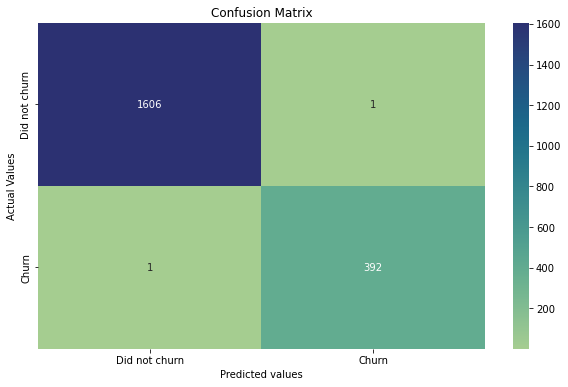

In [373]:
evaluate(LR_model)

### Without Complain

In [375]:
parameters = {'model__C':[0.01,0.1,1], 
              'model__penalty':['l2'], 
              'model__solver':['lbfgs','newton-cholesky']}
LR_model2 = build_model(LogisticRegression(random_state=42), parameters, excludeComplain=True)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


The best parameters are: {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
The best score on training set is: 0.806
Accuracy on test set:  0.812
ROC score:  0.7810928966940122
The classification scores are:
              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89      1895
         1.0       0.16      0.58      0.24       105

    accuracy                           0.81      2000
   macro avg       0.56      0.70      0.57      2000
weighted avg       0.93      0.81      0.86      2000



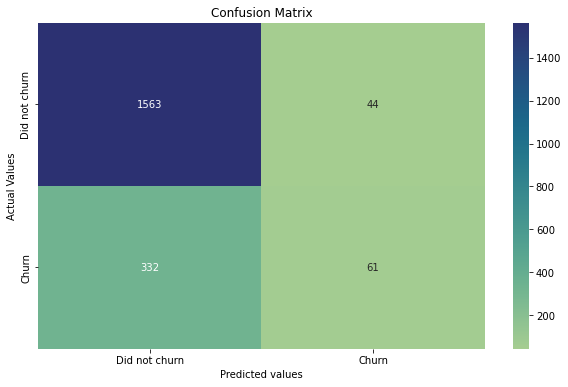

In [376]:
evaluate(LR_model2, True)

We can see that the model performance dropped significantly when Complain is not included as a one of the features. We know that Complain is one of the key drivers for churning customers. Thus, now we want to find out whether there is other customer segments that drives churning customers. Now we are going to exclude Complain as a feature.  

Logistic Regression is our base model. It is a good indicator whether other classifiers can improve from Logistic Regression and make comparison.

## Decision Tree Classification

In [377]:
parameters = {'model__min_samples_split':[2,8],
              'model__max_depth':[2,4,8], 
              'model__max_features':[5,10],
              'model__class_weight':[{0:1,1:2}, {0:1,1:1.5}]}
tree_model = build_model(DecisionTreeClassifier(random_state=42), parameters, excludeComplain=True)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


The best parameters are: {'model__class_weight': {0: 1, 1: 2}, 'model__max_depth': 2, 'model__max_features': 5, 'model__min_samples_split': 2}
The best score on training set is: 0.745625
Accuracy on test set:  0.7565
ROC score:  0.732778508782347
The classification scores are:
              precision    recall  f1-score   support

         0.0       0.79      0.90      0.84      1416
         1.0       0.62      0.42      0.50       584

    accuracy                           0.76      2000
   macro avg       0.71      0.66      0.67      2000
weighted avg       0.74      0.76      0.74      2000



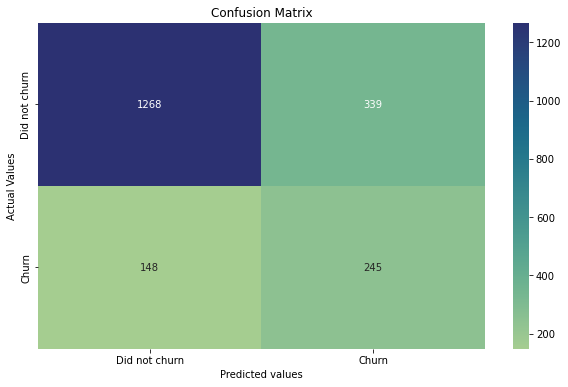

In [378]:
evaluate(tree_model, True)

## Random Forest Classification

Ensemble models can boost performance by combining multiple algorithms to learn the data. Random Forest is one of example of Ensemble models. It uses bagging technique which uses multiple decision trees.

In [383]:
parameters={'model__n_estimators':[100,200], 
            'model__class_weight':[{0:1,1:2}, {0:1,1:1.5}],
            'model__max_depth':[2,4,8],
            'model__max_features':[5,15]}
rf_model = build_model(RandomForestClassifier(random_state=42), parameters, excludeComplain=True)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


The best parameters are: {'model__class_weight': {0: 1, 1: 2}, 'model__max_depth': 2, 'model__max_features': 5, 'model__n_estimators': 100}
The best score on training set is: 0.8355
Accuracy on test set:  0.8405
ROC score:  0.8249476289325803
The classification scores are:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.91      1900
         1.0       0.22      0.87      0.35       100

    accuracy                           0.84      2000
   macro avg       0.61      0.85      0.63      2000
weighted avg       0.95      0.84      0.88      2000



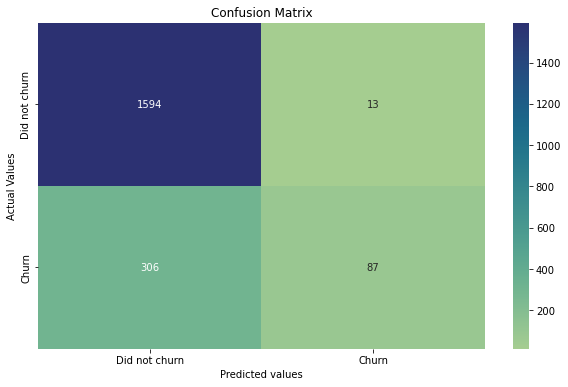

In [384]:
evaluate(rf_model, True)

## Gradient Boosting

Gradient boosting is another ensemble model that utilises boosting technique. 

In [388]:
parameters = {'model__n_estimators':[100,150], 
              'model__learning_rate':[0.1,0.2],
              'model__max_features':[5,10],
              'model__subsample':[1,0.9]}
gb_model = build_model(GradientBoostingClassifier(random_state=42), parameters, excludeComplain=True)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


The best parameters are: {'model__learning_rate': 0.1, 'model__max_features': 5, 'model__n_estimators': 100, 'model__subsample': 1}
The best score on training set is: 0.87025
Accuracy on test set:  0.8605
ROC score:  0.8683819675687316
The classification scores are:
              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92      1760
         1.0       0.45      0.74      0.56       240

    accuracy                           0.86      2000
   macro avg       0.71      0.81      0.74      2000
weighted avg       0.90      0.86      0.87      2000



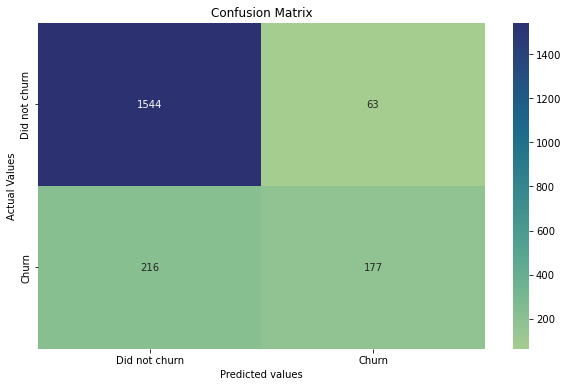

In [389]:
evaluate(gb_model, True)

## Model Performance Comparison

In [393]:
scores_df = pd.DataFrame(scores, index=['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting'])
scores_df

,test_acc,train_acc,roc_auc
Logistic Regression,0.8120,0.806000,0.781093
Decision Tree1,0.7565,0.745625,0.732779
Random Forest,0.8405,0.835500,0.824948
Gradient Boosting,0.8605,0.870250,0.868382


[(0.7, 0.9)]

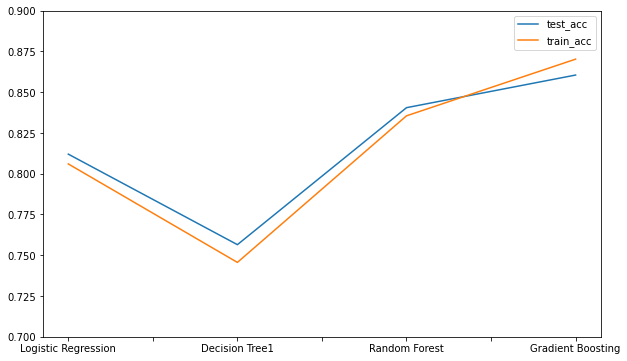

In [394]:
ax = scores_df.drop('roc_auc',axis=1).plot(kind='line', rot=0, figsize=(10,6))
ax.set(ylim=[0.7,0.9])

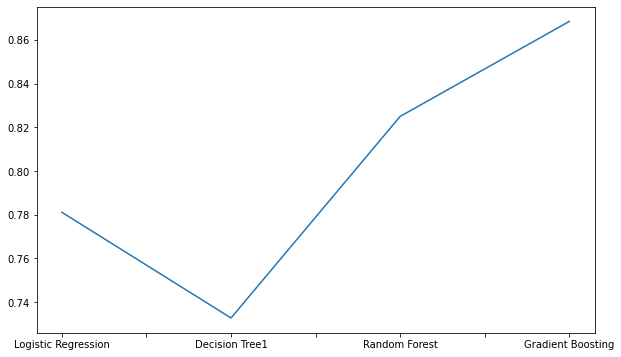

In [395]:
ax = scores_df['roc_auc'].plot(kind='line', rot=0, figsize=(10,6))

There is a small improvement in validation score from logistic regression model. Ensemble methods are great here. Random Forest and Gradient Boosting models have significant increase in performance. The ROC score also increases from logistic regression and decision tree.  

In conclusion, one of the main driver of churning customer is complain. We know this finding based on our exploration and further proved it with building ML models. When building models without complain as a feature, performance dropped significantly. So, I decided to investigate whether there are other features that interact with churn well. 

Several models were built including Logistic Regression (our base model), decision tree, random forest, and gradient boosting. Overall, gradient boosting model is chosen here as the best model for predicting churn. While random forest has slightly higher test accuracy, gradient boosting has better ROC score. ROC score is a measure to evaluate whether model can distinguish binary classes. 

The main features that drive customer churn will be discovered in the next phase using recursive feature elimination (RFE) and cross validation (CV). I will also experiment using resample method to find out if it will improve the f1-score for `1` class (churn).

Current model performance benchmark (GB):

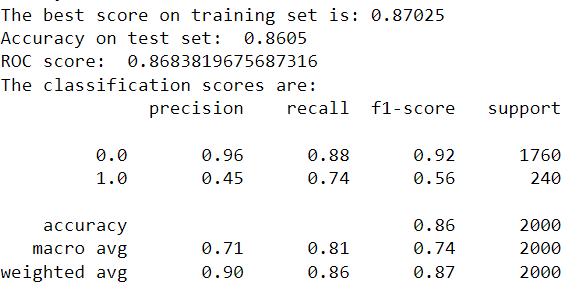

In [ ]:
import pickle
pickle.dump(gb, open('model.pkl', 'wb'))

## RFECV

In [27]:
estimator = GradientBoostingClassifier(random_state=42, criterion='friedman_mse', learning_rate= 0.2, 
                                       max_features=10, n_estimators=100, subsample=0.9)

rfecv = RFECV(estimator=estimator, cv=StratifiedKFold(n_splits=5))
rfecv.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=GradientBoostingClassifier(learning_rate=0.2, max_features=10,
                                           random_state=42, subsample=0.9))

In [28]:
selected_features = X_train.columns[rfecv.support_]
selected_features

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'IsActiveMember', 'EstimatedSalary', 'Satisfaction Score',
       'Point Earned', 'Female', 'Male', 'Germany'],
      dtype='object')

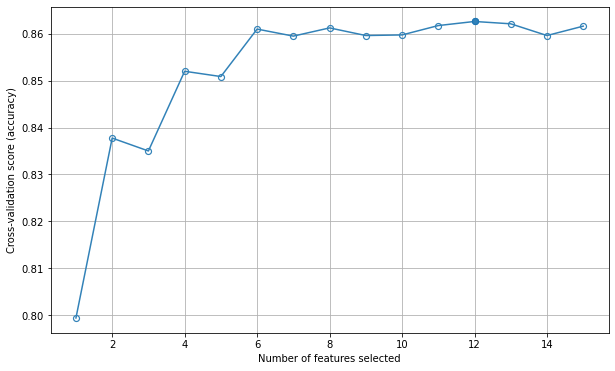

In [29]:
plt.figure()
plt.grid(True)
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'],
        marker='o', color='#3282b8', markerfacecolor = 'None', markeredgecolor = '#3282b8', markeredgewidth = 1.2)
plt.plot(12, rfecv.cv_results_['mean_test_score'][11], marker='o', markerfacecolor = '#3282b8', markeredgewidth = 1.2)
plt.show()

The accuracy peaks with 12 features selected. The accuracy scores starts increasing after 1 feature and stopped after 6 features.

### Features importance

In [30]:
estimator.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_features=10, random_state=42,
                           subsample=0.9)

In [31]:
sort_indices = estimator.feature_importances_.argsort()
X_train.columns[sort_indices]

Index(['HasCrCard', 'Spain', 'Satisfaction Score', 'Female', 'France',
       'Tenure', 'Male', 'Point Earned', 'CreditScore', 'EstimatedSalary',
       'Germany', 'Balance', 'IsActiveMember', 'NumOfProducts', 'Age'],
      dtype='object')

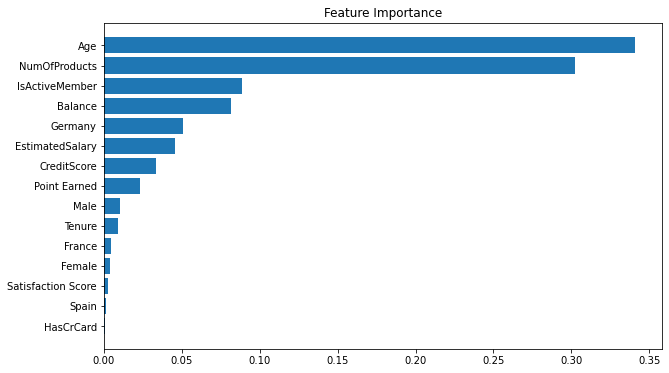

In [32]:
plt.figure()
plt.title("Feature Importance")
plt.barh(range(X_train.shape[1]), estimator.feature_importances_[sort_indices])
plt.yticks(range(X_train.shape[1]), X_train.columns[sort_indices], rotation=0)
plt.show()

From the chart it can be seen that the top 3 features are age, number of products with the bank, and active member status. However, age and number of products are the most influential features in determining churn due to the contribution value it holds.

Overall, the bank should focus on building better experience for their customer. This can be solved from the complains that the bank have received as this is the main driver. Furthermore, age is also important in determining churn, the further exploration of which age group churned in the past will be conducted. Lastly, number of products that the customer has with the bank is also crucial. Increasing bank products as well as its quality will prevent customer from churning.

### Exploring Age group

In [33]:
data['Age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: Age, dtype: float64

In [34]:
group = [18,20,30,40,50,60,70,93]
labels = ['<20', '20s', '30s','40s','50s','60s','>70']
data['Age_group']=pd.cut(data['Age'], bins=group, labels=labels, right=False)

In [35]:
data.head(10)

,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Complain,Satisfaction Score,Card Type,Point Earned,Female,Male,France,Germany,Spain,Age_group
0,15634602,Hargrave,619,42,2,0.00,1,1,1,101348.88,...,1,2,DIAMOND,464,1,0,1,0,0,40s
1,15647311,Hill,608,41,1,83807.86,1,0,1,112542.58,...,1,3,DIAMOND,456,1,0,0,0,1,40s
2,15619304,Onio,502,42,8,159660.80,3,1,0,113931.57,...,1,3,DIAMOND,377,1,0,1,0,0,40s
3,15701354,Boni,699,39,1,0.00,2,0,0,93826.63,...,0,5,GOLD,350,1,0,1,0,0,30s
4,15737888,Mitchell,850,43,2,125510.82,1,1,1,79084.10,...,0,5,GOLD,425,1,0,0,0,1,40s
5,15574012,Chu,645,44,8,113755.78,2,1,0,149756.71,...,1,5,DIAMOND,484,0,1,0,0,1,40s
6,15592531,Bartlett,822,50,7,0.00,2,1,1,10062.80,...,0,2,SILVER,206,0,1,1,0,0,50s
7,15656148,Obinna,376,29,4,115046.74,4,1,0,119346.88,...,1,2,DIAMOND,282,1,0,0,1,0,20s
8,15792365,He,501,44,4,142051.07,2,0,1,74940.50,...,0,3,GOLD,251,0,1,1,0,0,40s
9,15592389,H?,684,27,2,134603.88,1,1,1,71725.73,...,0,3,GOLD,342,0,1,1,0,0,20s


<AxesSubplot:xlabel='Age_group', ylabel='count'>

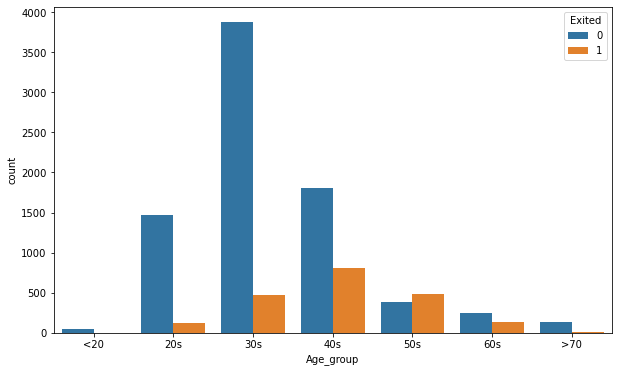

In [36]:
sns.countplot(x=data['Age_group'], hue=data['Exited'])

Most of the customers who churn are located in the 40s age group.

## Resampling Method (Equal samples for each class target)

In [37]:
from sklearn.utils import resample

train_data = pd.concat([X_train, y_train], axis=1)
major_class = train_data.loc[train_data['Exited']=='0']
minor_class = train_data.loc[train_data['Exited']=='1']
minor_upsampled = resample(minor_class, replace=True, n_samples=len(major_class),
                          random_state=42)
upsampled_df = pd.concat([major_class, minor_upsampled])
X_train = upsampled_df.drop('Exited', axis=1)
y_train = upsampled_df['Exited']

## Logistic Regression

In [38]:
parameters = {'model__C':[0.01,0.1,1], 
              'model__penalty':['l2'], 
              'model__solver':['lbfgs','newton-cholesky']}
LR_model = build_model(LogisticRegression(random_state=42), parameters)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [39]:
evaluate(LR_model)

The best parameters are: {'model__C': 0.01, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
The best score on training set is: 0.6986624704956728
Accuracy on test set:  0.7185
The classification scores are:
              precision    recall  f1-score   support

           0       0.72      0.91      0.80      1268
           1       0.72      0.38      0.50       732

    accuracy                           0.72      2000
   macro avg       0.72      0.65      0.65      2000
weighted avg       0.72      0.72      0.69      2000



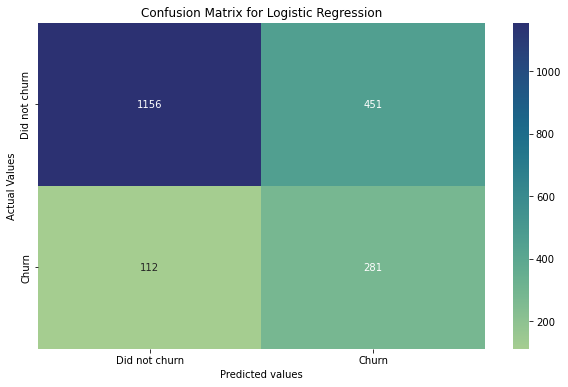

In [40]:
plot_cm(LR_model, 'Logistic Regression')

The accuracy score is lower than with imbalanced dataset. This can indicate that earlier model may not generalise to outside data.

## Gradient Boosting Classification

In [41]:
parameters = {'model__n_estimators':[100], 
              'model__criterion':['friedman_mse', 'squared_error'],
              'model__learning_rate':[0.1,0.2],
              'model__max_features':[5,10,None],
              'model__subsample':[1,0.9]}
gb_model = build_model(GradientBoostingClassifier(random_state=42), parameters)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [42]:
evaluate(gb_model)

The best parameters are: {'model__criterion': 'friedman_mse', 'model__learning_rate': 0.2, 'model__max_features': None, 'model__n_estimators': 100, 'model__subsample': 1}
The best score on training set is: 0.8146341463414635
Accuracy on test set:  0.8165
The classification scores are:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1426
           1       0.76      0.52      0.62       574

    accuracy                           0.82      2000
   macro avg       0.80      0.73      0.75      2000
weighted avg       0.81      0.82      0.80      2000



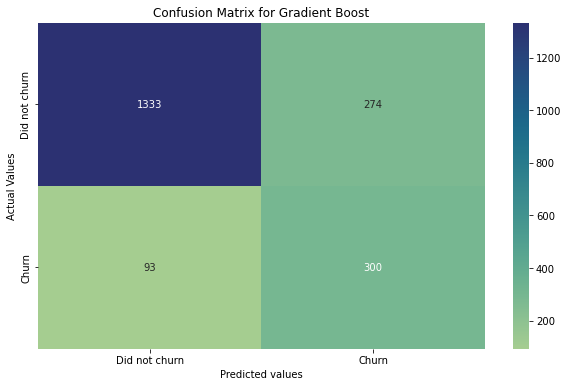

In [43]:
plot_cm(gb_model, 'Gradient Boost')

The accuracy score is better now. Recall has increased greatly with gradient boosting. Now, we need to repeat the same process using RFECV.

In [44]:
estimator = GradientBoostingClassifier(random_state=42, criterion='friedman_mse', learning_rate= 0.2, 
                                       max_features=None, n_estimators=100, subsample=1)

rfecv = RFECV(estimator=estimator, cv=StratifiedKFold(n_splits=5))
rfecv.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=GradientBoostingClassifier(learning_rate=0.2, random_state=42,
                                           subsample=1))

In [45]:
selected_features = X_train.columns[rfecv.support_]
selected_features

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'IsActiveMember', 'EstimatedSalary', 'Satisfaction Score',
       'Point Earned', 'Female', 'Germany'],
      dtype='object')

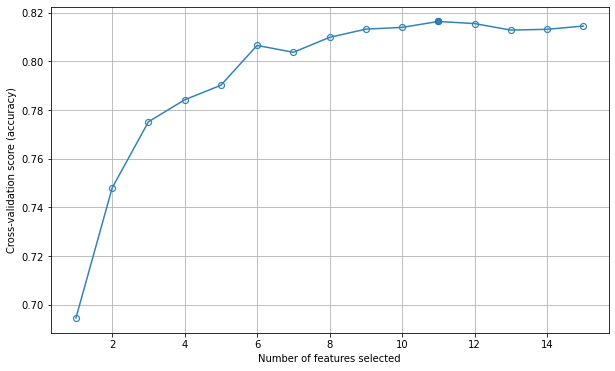

In [46]:
plt.figure()
plt.grid(True)
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (accuracy)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'],
        marker='o', color='#3282b8', markerfacecolor = 'None', markeredgecolor = '#3282b8', markeredgewidth = 1.2)
plt.plot(11, rfecv.cv_results_['mean_test_score'][10], marker='o', markerfacecolor = '#3282b8', markeredgewidth = 1.2)
plt.show()

With balanced dataset/resample, the accuracy score peaks with 11 features. The accuracy stopped increasing after 6 features which is the same with earlier experiment.

In [47]:
estimator.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, random_state=42, subsample=1)

In [48]:
sort_indices = estimator.feature_importances_.argsort()
X_train.columns[sort_indices]

Index(['HasCrCard', 'Spain', 'Satisfaction Score', 'France', 'Female', 'Male',
       'Tenure', 'CreditScore', 'Point Earned', 'EstimatedSalary', 'Germany',
       'IsActiveMember', 'Balance', 'NumOfProducts', 'Age'],
      dtype='object')

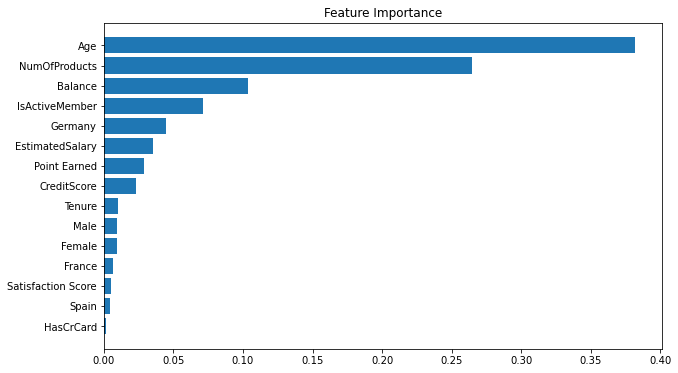

In [49]:
plt.figure()
plt.title("Feature Importance")
plt.barh(range(X_train.shape[1]), estimator.feature_importances_[sort_indices])
plt.yticks(range(X_train.shape[1]), X_train.columns[sort_indices], rotation=0)
plt.show()

The top 2 features are still age and number of products. The difference is in the third place which now has became balance. 